# Check the cell counts across hearts

In [1]:
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load in QC profiles from all annotated parquet files (both plates)
data_dir = pathlib.Path("../3.preprocessing_profiles/data/single_cell_profiles")
annotated_files = sorted(data_dir.glob("*_annotated.parquet"))

if not annotated_files:
    raise FileNotFoundError(f"No annotated parquet files found in {data_dir}")

dfs = []
for p in annotated_files:
    df_tmp = pd.read_parquet(p)
    # keep track of source plate/file
    df_tmp["source_plate_file"] = p.name
    dfs.append(df_tmp)

# Concatenate into one profile_df for downstream cells
profile_df = pd.concat(dfs, ignore_index=True)

print("Loaded annotated files:", [p.name for p in annotated_files])
print("Combined Profile DataFrame shape:", profile_df.shape)
profile_df.head()

Loaded annotated files: ['CARD-CelIns-CX7_251023130003_sc_annotated.parquet', 'CARD-CelIns-CX7_251110170001_sc_annotated.parquet']
Combined Profile DataFrame shape: (19701, 2484)


,Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_treatment,Metadata_cell_type,Metadata_heart_failure_type,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,...,Nuclei_Texture_Variance_Mitochondria_3_00_256,Nuclei_Texture_Variance_Mitochondria_3_01_256,Nuclei_Texture_Variance_Mitochondria_3_02_256,Nuclei_Texture_Variance_Mitochondria_3_03_256,Nuclei_Texture_Variance_PM_3_00_256,Nuclei_Texture_Variance_PM_3_01_256,Nuclei_Texture_Variance_PM_3_02_256,Nuclei_Texture_Variance_PM_3_03_256,Outlier_Status,source_plate_file
0,B,2,2,DMSO,Healthy,None,222.515520,91.821668,227.192782,133.566315,...,0.507924,0.503667,0.532190,0.508049,1.454409,1.388667,1.442516,1.428607,Single-cell passed QC,CARD-CelIns-CX7_251023130003_sc_annotated.parquet
1,B,2,2,DMSO,Healthy,None,257.395516,243.480384,229.375293,218.997448,...,1.382701,1.374174,1.393571,1.378798,2.637957,2.621789,2.650389,2.600068,Single-cell passed QC,CARD-CelIns-CX7_251023130003_sc_annotated.parquet
2,B,2,2,DMSO,Healthy,None,544.413009,128.311129,568.124140,217.837756,...,3.138237,2.800625,2.891212,2.940394,1.689882,1.797593,1.678715,1.659584,Single-cell passed QC,CARD-CelIns-CX7_251023130003_sc_annotated.parquet
3,B,2,2,DMSO,Healthy,None,461.582781,64.372517,477.790045,65.533781,...,13.312398,13.267851,13.046487,12.301941,25.543819,26.286346,24.961104,23.806633,Single-cell passed QC,CARD-CelIns-CX7_251023130003_sc_annotated.parquet
4,B,2,2,DMSO,Healthy,None,306.047773,204.265332,293.359455,192.636878,...,1.366019,1.249328,1.205906,1.233750,0.850228,0.862562,0.874679,0.850847,Single-cell passed QC,CARD-CelIns-CX7_251023130003_sc_annotated.parquet


In [3]:
# split heart 2 by treatment and plot and add to profile_df
profile_df["heart_treatment"] = profile_df["Metadata_heart_number"].astype(str)
mask = profile_df["Metadata_heart_number"] == 2
profile_df.loc[mask, "heart_treatment"] = (
    profile_df.loc[mask, "Metadata_heart_number"].astype(str)
    + "_"
    + profile_df.loc[mask, "Metadata_treatment"].fillna("None").astype(str)
)
print("Profile DataFrame shape:", profile_df.shape)

Profile DataFrame shape: (19701, 2485)


Plot saved to: ../4.EDA/figures/cell_counts_per_heart_treatment.png


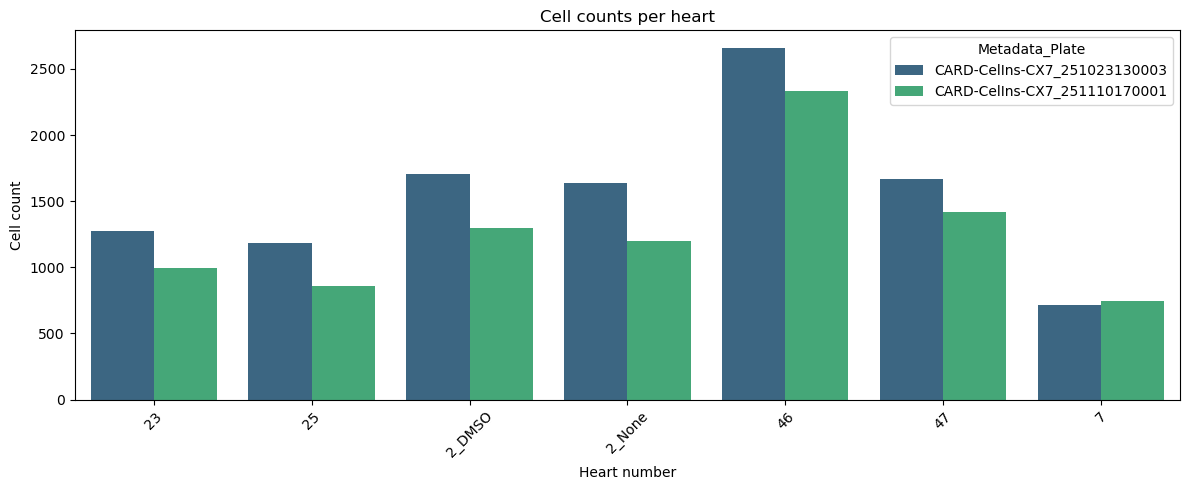

In [4]:
# Compute counts per heart and plate
counts_df = (
    profile_df.groupby(["heart_treatment", "Metadata_Plate"])
    .size()
    .reset_index(name="cell_count")
)

plt.figure(figsize=(12, 5))
sns.barplot(
    data=counts_df,
    x="heart_treatment",
    y="cell_count",
    hue="Metadata_Plate",
    palette="viridis",
)
plt.xticks(rotation=45)
plt.xlabel("Heart number")
plt.ylabel("Cell count")
plt.title("Cell counts per heart")
plt.tight_layout()
# Save plot
output_plot_dir = pathlib.Path("../4.EDA/figures")
output_plot_dir.mkdir(parents=True, exist_ok=True)
output_plot_path = output_plot_dir / "cell_counts_per_heart_treatment.png"
plt.savefig(output_plot_path)
print("Plot saved to:", output_plot_path)
plt.show()

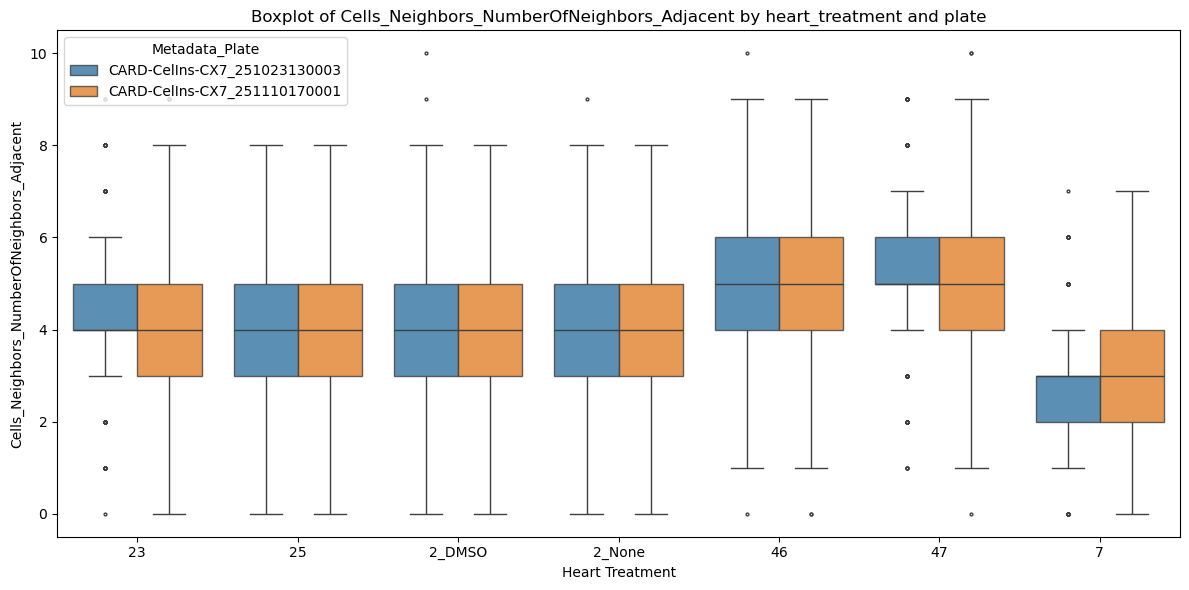

In [5]:
# Define the column to plot
col = "Cells_Neighbors_NumberOfNeighbors_Adjacent"

# Determine order automatically from the data
order = sorted(profile_df["heart_treatment"].dropna().unique())

plt.figure(figsize=(12, 6))

sns.boxplot(
    data=profile_df.dropna(subset=[col]),
    x="heart_treatment",
    y=col,
    hue="Metadata_Plate",
    order=order,
    showcaps=True,
    fliersize=2,
    boxprops={"alpha": 0.8},
)

plt.xlabel("Heart Treatment")
plt.ylabel(col)
plt.title(f"Boxplot of {col} by heart_treatment and plate")
plt.tight_layout()
plt.show()